In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

In [2]:
# Here are the units we'll need

s = UNITS.second
N = UNITS.newton
kg = UNITS.kilogram
m = UNITS.meter
y = UNITS.year

<Unit('year')>

In [3]:
# And an inition condition (with everything in SI units)

x_0 = 147e9 * m
y_0 = 0 *m 
vx_0 = 0 * m/s
vy_0 = 30330 * m/s

init = State(x = x_0,
             y = y_0,
             vx = vx_0,
             vy = vy_0,)
print(init)

x       147000000000.0 meter
y                    0 meter
vx        0.0 meter / second
vy    30330.0 meter / second
dtype: object


In [4]:
# Making a system object

r_earth = 6.371e6 * m
r_sun = 695.508e6 * m

system = System(init=init,
                G=6.674e-11 * N / kg**2 * m**2,
                m1=1.989e30 * kg,
                r_final=r_sun + r_earth,
                m2=5.972e24 * kg,
                t_0=0 * s,
                t_end=1e7 * s)

,values
init,x 147000000000.0 meter y ...
G,6.674e-11 meter ** 2 * newton / kilogram ** 2
m1,1.989e+30 kilogram
r_final,701879000.0 meter
m2,5.972e+24 kilogram
t_0,0 second
t_end,10000000.0 second


In [5]:
def universal_gravitation2(state, system):
    """Computes gravitational force.
    
    state: State object with distance r
    system: System object with m1, m2, and G
    """
    x, y, vx, vy, = state
    unpack(system)
    
    r = Vector(x,y)
    force = G * m1 * m2 / r.mag**2 
    force_d = -r.hat() * force
    return force_d

In [6]:
universal_gravitation2(init,system)

<Quantity([-3.6686486e+22 -0.0000000e+00], 'newton')>

In [7]:
def slope_func2(state, t, system):
    """Compute derivatives of the state.
    
    state: position, velocity
    t: time
    system: System object containing `g`
    
    returns: derivatives of y and v
    """
    x, y, vx, vy = state
    unpack(system)    

    force_vector = universal_gravitation2(state, system)
    r = Vector(x,y)
    # calculate derivatives
    dxdt = vx
    dydt = vy
    accelerationVector = force_vector / m2
    #print(accelerationVector.x.mag)
    return dxdt, dydt, accelerationVector.x.mag, accelerationVector.y.mag

In [8]:
# new slope_func that works because last one didn't for some reason
def slope_func3(state, t, system):
    """Compute derivatives of the state.
    
    state: position, velocity
    t: time
    system: System object containing `g`
    
    returns: derivatives of y and v
    """
    
    x, y, vx, vy = state
    unpack(system) 
    r = Vector(x,y)
    
    force_vector = universal_gravitation2(state, system)
    a = force_vector / m2
    
    return vx, vy, a.x, a.y

In [9]:
# testing slope_func3

slope_func3(init, 0, system)

(<Quantity(0.0, 'meter / second')>,
 <Quantity(30330.0, 'meter / second')>,
 <Quantity(-0.006143082049146188, 'newton / kilogram')>,
 <Quantity(-0.0, 'newton / kilogram')>)

In [10]:
#Running simulation
results, details = run_ode_solver(system, slope_func3)
details

,values
sol,None
t_events,[]
nfev,110
njev,0
nlu,0
status,0
message,The solver successfully reached the end of the...
success,True


In [11]:
results

,x,y,vx,vy
0.000000e+00,1.470000e+11,0.000000e+00,0.000000e+00,30330.000000
4.662755e-08,1.470000e+11,1.414214e-03,-2.864369e-10,30330.000000
5.129030e-07,1.470000e+11,1.555635e-02,-3.150805e-09,30330.000000
5.175658e-06,1.470000e+11,1.569777e-01,-3.179449e-08,30330.000000
5.180321e-05,1.470000e+11,1.571191e+00,-3.182313e-07,30330.000000
5.180787e-04,1.470000e+11,1.571333e+01,-3.182600e-06,30330.000000
5.180834e-03,1.470000e+11,1.571347e+02,-3.182629e-05,30330.000000
5.180838e-02,1.470000e+11,1.571348e+03,-3.182631e-04,30330.000000
5.180839e-01,1.470000e+11,1.571348e+04,-3.182632e-03,30330.000000
5.180839e+00,1.470000e+11,1.571348e+05,-3.182632e-02,30330.000000


In [12]:
# Here's how long it takes...

t_final = get_last_label(results) * s

<Quantity(10000000.0, 'second')>

In [13]:
r_final

<Quantity(701879000.0, 'meter')>

,x,y,vx,vy
0.000000e+00,1.470000e+11,0.000000e+00,0.000000e+00,30330.000000
4.662755e-08,1.470000e+11,1.414214e-03,-2.864369e-10,30330.000000
5.129030e-07,1.470000e+11,1.555635e-02,-3.150805e-09,30330.000000
5.175658e-06,1.470000e+11,1.569777e-01,-3.179449e-08,30330.000000
5.180321e-05,1.470000e+11,1.571191e+00,-3.182313e-07,30330.000000
5.180787e-04,1.470000e+11,1.571333e+01,-3.182600e-06,30330.000000
5.180834e-03,1.470000e+11,1.571347e+02,-3.182629e-05,30330.000000
5.180838e-02,1.470000e+11,1.571348e+03,-3.182631e-04,30330.000000
5.180839e-01,1.470000e+11,1.571348e+04,-3.182632e-03,30330.000000
5.180839e+00,1.470000e+11,1.571348e+05,-3.182632e-02,30330.000000


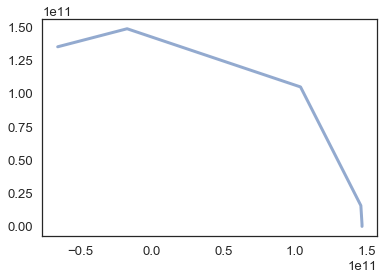

In [14]:
plot(results.x, results.y)
results

In [15]:
t_final = get_last_label(results) * s

<Quantity(10000000.0, 'second')>

In [16]:
x_0 = 147e9 * m
y_0 = 0 *m 
vx_0 = 0 * m/s
vy_0 = 30330 * m/s

init = State(x = x_0,
             y = y_0,
             vx = vx_0,
             vy = vy_0,)

,values
x,147000000000.0 meter
y,0 meter
vx,0.0 meter / second
vy,30330.0 meter / second


In [17]:
r_earth = 6.371e6 * m
r_sun = 695.508e6 * m

system = System(init=init,
                G=6.674e-11 * N / kg**2 * m**2,
                m1=1.989e30 * kg,
                r_final=r_sun + r_earth,
                m2=5.972e24 * kg,
                t_0=0 * s,
                t_end=60 * 60 * 24 * 365 * s)


,values
init,x 147000000000.0 meter y ...
G,6.674e-11 meter ** 2 * newton / kilogram ** 2
m1,1.989e+30 kilogram
r_final,701879000.0 meter
m2,5.972e+24 kilogram
t_0,0 second
t_end,31536000 second


In [18]:
#more time steps and changes ODE solver method
t_0=0 * s
t_end=60 * 60 * 24 * 365 * s
ts = linspace(t_0, t_end, 201)
results, details = run_ode_solver(system, slope_func3, t_eval=ts, method = 'RK23')

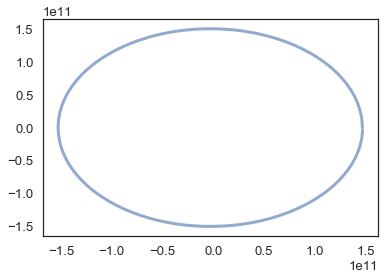

In [19]:
plot(results.x, results.y)

In [20]:
#turns results into millions of km
results.x /= 1e9
results.y /= 1e9

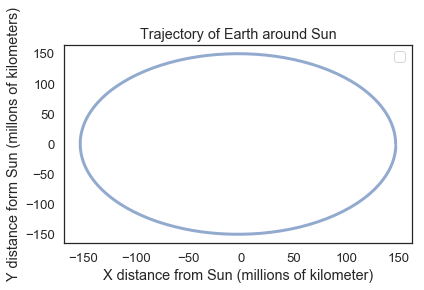

In [24]:
#plots results with labels
plot(results.x, results.y)
decorate(xlabel='X distance from Sun (millions of kilometer)',
        ylabel='Y distance form Sun (millons of kilometers)',
        title = 'Trajectory of Earth around Sun')